### Exploring Your Data
After you’ve identified the questions you’re trying to answer and have gotten your hands
on some data, you might be tempted to dive in and immediately start building models and
getting answers. But you should resist this urge. Your first step should be to explore your
data.

##### Exploring One-Dimensional Data
The simplest case is when you have a one-dimensional data set, which is just a collection
of numbers. For example, these could be the daily average number of minutes each user
spends on your site, the number of times each of a collection of data science tutorial
videos was watched, or the number of pages of each of the data science books in your data
science library.

An obvious first step is to compute a few summary statistics. You’d like to know how
many data points you have, the smallest, the largest, the mean, and the standard deviation.
But even these don’t necessarily give you a great understanding. A good next step is to
create a histogram, in which you group your data into discrete buckets and count how
many points fall into each bucket:

In [3]:
def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    """find approximate inverse using binary search"""
    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    low_z, low_p = -10.0, 0 # normal_cdf(-10) is (very close to) 0
    hi_z, hi_p = 10.0, 1 # normal_cdf(10) is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2 # consider the midpoint
        mid_p = normal_cdf(mid_z) # and the cdf's value there
        if mid_p < p:
            # midpoint is still too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # midpoint is still too high, search below it
            hi_z, hi_p = mid_z, mid_p
        else:
            break
    return mid_z
    """The function repeatedly bisects intervals until it narrows in on a Z that’s close enough to
        the desired probability."""

In [4]:
import math
from collections import Counter
import matplotlib.pyplot as plt

def normal_cdf(x, mu=0,sigma=1):
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

def bucketize(point,bucket_size):
    """floor the point to next lower multiple of bucket size"""
    return bucket_size * math.floor(point/bucket_size)
def make_histogram(points , bucket_size):
    return Counter(bucketize(point,bucket_size) for point in points)

def plot_histogram(points , bucket_size , title=""):
    histogram = make_histogram(points,bucket_size)
    plt.bar(histogram.keys() , histogram.values() , width=bucket_size)
    plt.title(title)
    plt.show()

In [6]:
import random
random.seed(0)
# uniform between -100 and 100
uniform = [200 * random.random() - 100 for _ in range(10000)]
# normal distribution with mean 0, standard deviation 57
normal = [57 * inverse_normal_cdf(random.random())
for _ in range(10000)]

Both have means close to 0 and standard deviations close to 58. However, they have very
different distributions.

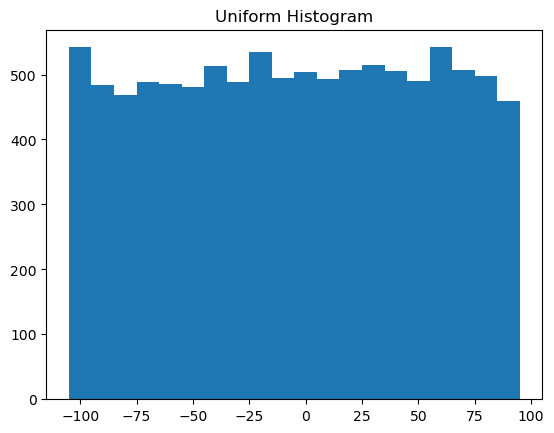

In [7]:
plot_histogram(uniform, 10, "Uniform Histogram")

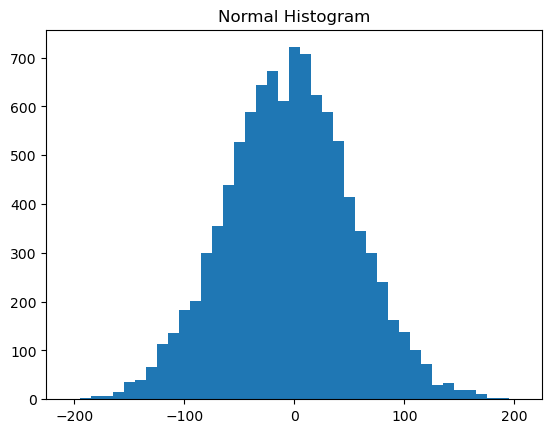

In [8]:
plot_histogram(normal, 10, "Normal Histogram")

In this case, both distributions had pretty different max and min, but even knowing that
wouldn’t have been sufficient to understand how they differed.